In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *


# define GPU id to use
# 0 = 1080 Bus ID 2
# 1 = Titan Bus ID 131
# 2 = Titan Bus ID 132
GPU_IDS = '1'
current_gpu = choose_gpu_by_id(GPU_IDS)
print(current_gpu)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

sys.path.append('src/models/ext/neuron')
sys.path.append('src/models/ext/pynd-lib')
sys.path.append('src/models/ext/pytools-lib')

# import helpers
from src.utils.utils_io import Console_and_file_logger, init_config
from src.visualization.visualize import show_2D_or_3D
from src.data.dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df
from src.data.generators import DataGenerator, get_samples, MotionDataGenerator
from src.utils.unet_3d_metrics import weighted_dice_coefficient_loss
from src.models.ModelManager import get_model
from src.utils.KerasCallbacks import get_callbacks
import src.utils.my_metrics as metr
from src.models.src.networks import cvpr2018_net
from keras.losses import mean_squared_error as mse
from src.models.src.losses import Grad
from src.visualization.visualize import create_quiver_plot


# define experiment name for report, model and log paths + filenames
EXPERIMENT = 'motion/3D/acdc/ES_ED_masked_myo/'
now = datetime.datetime.now()

# image params, change for different input data/architecture
ARCHITECTURE = '3D' # 2D
DIM = [16, 224, 224] # [16,244,244]

SPACING = [7, 1.0,1.0] # used by sitk, opposite order than numpy or tensorflow!
IMG_CHANNELS = 1
MASK_VALUES = [0, 1, 2, 3]  
MASK_CLASSES = len(MASK_VALUES)
# Background = 0 = Y[:,:,0]
# RV = 1 = Y[:,:,1] 
# Myo = 2 = Y[:,:,2] 
# LV = 3 = Y[:,:,3]
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = False

# path params
DATASET = 'gcn'

MODEL_PATH = os.path.join(os.path.join('models', EXPERIMENT), str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join(os.path.join('reports/tensorboard_logs', EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join(os.path.join('reports/configs/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join(os.path.join('reports/history/',EXPERIMENT),str(now.strftime("%Y-%m-%d_%H_%M")))

# training params
GENERATOR_WORKER = 4 # if not set, use batchsize
seed = 42
BATCHSIZE =  1 # 32, 64, 24, 16, 1
INITIAL_EPOCH = 0
EPOCHS = 150
FOLDS = 4
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MASKING_VALUES = [2]
MASKING_IMAGE = True

# Network params
OPTIMIZER = 'Adam'  # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu'  # 'elu' --> works well with binary_crossentropy and bce_dice_loss, relu does not work, it clips negative values, bse does return negative values
LEARNING_RATE = 0.001
DECAY = 0.0
EPSILON = 1e-08
DROPOUT_L1_L2 = 0.4 # higher dropout at the deeper layers
DROPOUT_L3_L4 = 0.4
DROPOUT_L5 = 0.5
BATCH_NORMALISATION = True
USE_UPSAMPLE = True # otherwise use transpose

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv,
]

LOSS_FUNCTION = metr.bce_dice_jac_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)


# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(locals(), True)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.


['gpu(0)']


INFO:root:-------------------- Start --------------------
2019-12-03 00:01:13,685 INFO -------------------- Start --------------------
INFO:root:Working directory: /mnt/data/git/cardio.
2019-12-03 00:01:13,686 INFO Working directory: /mnt/data/git/cardio.
INFO:root:Log file: ./logs/motion/3D/acdc/ES_ED_masked_myo/.log
2019-12-03 00:01:13,687 INFO Log file: ./logs/motion/3D/acdc/ES_ED_masked_myo/.log


# Load 3D slices from patients with 5 labelled timesteps

In [2]:
#logging.getLogger().setLevel(logging.DEBUG)
# ACDC
from src.data.dataset import get_acdc_dataset_as_df
df = get_acdc_dataset_as_df('data/raw/ACDC/original/all/')
phase1 = df[df['phase']=='es']['files'].values
phase2 = df[df['phase']=='ed']['files'].values
#GCN
# just train on the motion between ED and ES --> Systolic phase
#df = pd.read_csv('reports/vae/3d_gcn.csv')
#phase1 = df[df['phase']=='ES']['x_path'].values
#phase2 = df[df['phase']=='ED']['x_path'].values
batch_generator = MotionDataGenerator(phase1, phase2, config)
len(phase1)
len(phase2)
df.head()

INFO:root:Create DataGenerator
2019-12-03 00:01:37,049 INFO Create DataGenerator
INFO:root:Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 100 
 Augment_grid: False 
 Thread workers: 4
2019-12-03 00:01:37,051 INFO Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 100 
 Augment_grid: False 
 Thread workers: 4
INFO:root:No augmentation
2019-12-03 00:01:37,051 INFO No augmentation


100

100

,index,pathology,patient,files,phase
0,0,DCM,patient001,data/raw/ACDC/original/all/patient001/Info.cfg,cfg
1,1,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,ed
2,2,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,ed_gt
3,3,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,es
4,4,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,es_gt


In [3]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(batch_generator), 1)):
    global x, y
    input_ , output_ = batch_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    logging.info(x.shape)
    logging.info(y.shape)

interactive(children=(IntSlider(value=50, description='batch'), Output()), _dom_classes=('widget-interact',))

In [4]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    show_2D_or_3D(x[im])
    plt.show()
    show_2D_or_3D(y[im])
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=0), Output()), _dom_classes=('widget-interact',…

In [5]:
# create a new model
model = cvpr2018_net(config.get('DIM', [16, 224, 224]), enc_nf=[16,32,32,32], dec_nf=[32,32,32,32,16,3])
model.compile(optimizer=keras.optimizers.Adam(), loss=['mse', Grad('l2').loss],
                         loss_weights=[1.0, 0.01]) # values used by the CVPR paper

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 224, 224, 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16, 224, 224, 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 16, 224, 224, 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 8, 112, 112,  880         concatenate_1[0][0]              
__________

In [7]:
plot_model(model, to_file=os.path.join(config.get('CONFIG_PATH'),'model.png'), show_shapes=True)

In [8]:
initial_epoch = 0
# training

# start a new main process for this training to free gpu memory afterwards
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit_generator(
    generator=batch_generator,
    epochs=200,
    callbacks = get_callbacks(config),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    max_queue_size=30,
    workers=8,
    #use_multiprocessing=True,
    verbose=1)

INFO:root:Fit model, start trainings process
2019-12-03 00:02:00,307 INFO Fit model, start trainings process


Epoch 1/200
100/100 [==============================] - 14s 139ms/step - loss: 0.0045 - spatial_transformer_1_loss: 0.0044 - flow_loss: 0.0040


INFO:root:Saved model to disk: models/motion/3D/acdc/ES_ED_masked_myo/2019-12-03_00_01
2019-12-03 00:02:19,189 INFO Saved model to disk: models/motion/3D/acdc/ES_ED_masked_myo/2019-12-03_00_01



Epoch 00001: loss improved from inf to 0.00445, saving model to models/motion/3D/acdc/ES_ED_masked_myo/2019-12-03_00_01/checkpoint.h5
Epoch 2/200
100/100 [==============================] - 8s 80ms/step - loss: 0.0025 - spatial_transformer_1_loss: 0.0024 - flow_loss: 0.0075

Epoch 00002: loss improved from 0.00445 to 0.00252, saving model to models/motion/3D/acdc/ES_ED_masked_myo/2019-12-03_00_01/checkpoint.h5
Epoch 3/200
100/100 [==============================] - 9s 93ms/step - loss: 0.0020 - spatial_transformer_1_loss: 0.0019 - flow_loss: 0.0079

Epoch 00003: loss improved from 0.00252 to 0.00202, saving model to models/motion/3D/acdc/ES_ED_masked_myo/2019-12-03_00_01/checkpoint.h5
Epoch 4/200
100/100 [==============================] - 9s 91ms/step - loss: 0.0017 - spatial_transformer_1_loss: 0.0017 - flow_loss: 0.0082

Epoch 00004: loss improved from 0.00202 to 0.00173, saving model to models/motion/3D/acdc/ES_ED_masked_myo/2019-12-03_00_01/checkpoint.h5
Epoch 5/200
100/100 [=======

In [3]:
@interact_manual
def load_config_interactive(config_file=sorted(glob.glob('reports/configs/motion/3D/gcn/ES_ED/**/*.json', recursive=False))):
    """
    load config, tranings history and model
    """
    from src.data.Dataset_utils import load_config
    logging.info(config_file)
    # load config with all params into global namespace, load = false --> no unet model loading
    glob_ = load_config(config_file=config_file, load=False)
    
    # update global namesspace to make config, model and evaluation score accessible
    globals().update(glob_)

    # load trained model
    # create a new empty model and load model weights
    # ED --> ES voxelmorph model 'models/motion/3D/gcn/2019-11-08_21_49'
    # ES --> ED vocelmorph model 'models/motion/3D/gcn/'
    # dataframe saved as 'reports/vae/3d_gcn_flowfield.csv'
    # vectorfields saved as 'data/interim/motion/3d/gcn/ed_es/'
    model_ = cvpr2018_net(config.get('DIM', [16, 224, 224]), enc_nf=[16,32,32,32], dec_nf=[32,32,32,32,16,3])
    logging.info('model created')
    #model_.compile(optimizer=keras.optimizers.Adam(), loss=['mse', Grad('l2').loss], loss_weights=[1.0, 0.01]) # values used by the CVPR paper
    model_.load_weights(os.path.join(config['MODEL_PATH'],'checkpoint.h5'))
    logging.info('weights loaded')
    globals()['model'] = model_
    logging.info('model and weights loaded successfully')

interactive(children=(Dropdown(description='config_file', options=('reports/configs/motion/3D/gcn/ES_ED/2019-1…

In [38]:
# ACDC
from src.data.dataset import get_acdc_dataset_as_df
df = get_acdc_dataset_as_df('data/raw/ACDC/original/all/')
#df = df[df['pathology'] == 'RV']
phase1 = df[df['phase']=='es']['files'].values
phase2 = df[df['phase']=='ed']['files'].values
df.pathology.unique()
#GCN
#df = pd.read_csv('reports/vae/3d_gcn.csv')
#phase1 = df[df['phase']=='ES']['x_path'].values
#phase2 = df[df['phase']=='ED']['x_path'].values
test_config = config.copy()
test_config['SHUFFLE'] = False
test_config['BATCHSIZE'] = 1
test_config['AUGMENT_GRID'] = False
test_generator = MotionDataGenerator(phase1, phase2, test_config)

array(['DCM', 'HCM', 'MINF', 'NOR', 'RV'], dtype=object)

INFO:root:Create DataGenerator
2019-12-03 15:15:41,173 INFO Create DataGenerator
INFO:root:Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 100 
 Augment_grid: False 
 Thread workers: 4
2019-12-03 15:15:41,174 INFO Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 100 
 Augment_grid: False 
 Thread workers: 4
INFO:root:No augmentation
2019-12-03 15:15:41,175 INFO No augmentation


In [39]:
df.head()

,index,pathology,patient,files,phase
0,0,DCM,patient001,data/raw/ACDC/original/all/patient001/Info.cfg,cfg
1,1,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,ed
2,2,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,ed_gt
3,3,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,es
4,4,DCM,patient001,data/raw/ACDC/original/all/patient001/patient0...,es_gt


In [40]:
# Select batch generator output
x = None
y = None
input_ = None
warped = None
flowfield = None
@interact
def select_batch(batch = (0,len(test_generator), 1)):
    global x, y, input_, warped, flowfield
    input_ , output_ = test_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    logging.info(x.shape)
    logging.info(y.shape)
    
    pred = model.predict(input_)
    warped, flowfield = pred
    warped.shape
    flowfield.shape
    flowfield[0].mean()

interactive(children=(IntSlider(value=50, description='batch'), Output()), _dom_classes=('widget-interact',))

In [35]:
@interact_manual
def show_flowfield(img = (0,x.shape[0]- 1)):
    
    from src.visualization.visualize import create_quiver_plot
    from src.data.preprocess import normalise_image
    
    nrows = x.shape[1]
    ncols = 7
    fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4,nrows*4))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    axes[0,0].set_title('X-flow')
    axes[0,1].set_title('Y-flow')
    axes[0,2].set_title('image phase 1')
    axes[0,3].set_title('image_warped')
    axes[0,4].set_title('image phase 2')
    axes[0,5].set_title('rgb flow')
    axes[0,6].set_title('quiver flowfield')
    
    for i in range(axes.shape[0]):
        
        axes[i,0].imshow(flowfield[img,i,:,:,1]);
        axes[i,1].imshow(flowfield[img,i,:,:,2]);
        axes[i,2].imshow(x[img,i,:,:,0], cmap='gray')
        axes[i,3].imshow(warped[img,i,:,:,0], cmap='gray') # x warped, should bee similar to y
        axes[i,4].imshow(y[img,i,:,:,0], cmap='gray') # target
        # diff_ = y[img,i,:,:,0]- warped[img,i,:,:,0]
        # axes[i,5].imshow(diff_) # difference
        axes[i,5].imshow(normalise_image(flowfield[img, i, :, :, :]))
        axes[i,6] = create_quiver_plot(flowfield[img, i], axes[i,6])

    plt.tight_layout()
    plt.savefig('reports/motion/3D/gcn/systolic_movement_example_2.svg')

interactive(children=(IntSlider(value=0, description='img', max=0), Button(description='Run Interact', style=B…

In [37]:
@interact
def plot_quiver_from_motion(img=(0,flowfield.shape[0]-1), z=(0, flowfield.shape[1]- 1)):
    
    """
    This is an interact method for Jupyter.
    For usage in a python module, params needs to be changed
    flowfield is a global variable with the shape batchsize, z-axis, x-axis, y-axis (output from Voxelmorph)
    :param img: int - index which image should be selected
    :param z: int - define the z-axis
    :return: plot image into jupyter
    """
    
    from src.data.preprocess import normalise_image, filter_small_vectors_batch
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    global x, flowfield, warped
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(34,6))
    
    print(flowfield.shape)
    
    ax1.set_title('Original image z={}'.format(z))
    ax1.imshow(x[img, z, :,:,0], cmap='gray')
    
    ax2 = create_quiver_plot(flowfield[img, z,...], ax2)
    
    ax3.set_title('RGB flow')
    flow = flowfield[img, z, ...].copy()
    flow_ = flowfield[img, z, ...].copy()
    im3 = ax3.imshow(normalise_image(flow))
    divider = make_axes_locatable(ax3)
    cax3 = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax3, orientation='vertical')
    
    filtered_flow = filter_small_vectors_batch(flow,(-0.05,0.05), (-0.2,0.2), (-0.3,0.3))
    im4 = ax4.imshow(filtered_flow)
    
    ax5.set_title('Target image  z={}'.format(z))
    ax5.imshow(y[img,z,:,:,0], cmap='gray')
    
    plt.savefig('reports/motion/3D/gcn/systolic_movement_example_filtered.png')
    plt.show()
    
    border = 50
    ax1 = create_quiver_plot(flow[border:-border,border:-border,:], N=3, scale=1)
    f_ = filter_small_vectors_batch(flow, normalize=False)
    ax2 = create_quiver_plot(f_[border:-border,border:-border,:], N=3, scale=1)
    plt.show()

interactive(children=(IntSlider(value=0, description='img', max=0), IntSlider(value=7, description='z', max=15…

# Predict Flowfields for all 3D GCN volumes, save Flowfields as numpy, save f_name in dataframe

In [38]:
#t1_df = pd.concat([df[df['t_norm'] == 0], df[df['t_norm'] == 1], df[df['t_norm'] == 2], df[df['t_norm'] == 3]])
#t2_df = pd.concat([df[df['t_norm'] == 1], df[df['t_norm'] == 2], df[df['t_norm'] == 3], df[df['t_norm'] == 4]])
#t1_df.shape

(808, 147)

In [41]:
test_config = config.copy()
test_config['SHUFFLE'] = False
test_config['BATCHSIZE'] = 1
test_config['AUGMENT_GRID'] = False
test_generator = MotionDataGenerator(phase1, phase2, test_config)

INFO:root:Create DataGenerator
2019-12-03 15:15:57,021 INFO Create DataGenerator
INFO:root:Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 100 
 Augment_grid: False 
 Thread workers: 4
2019-12-03 15:15:57,023 INFO Datagenerator created with: 
 shape: [16, 224, 224]
 batchsize: 1
 Scaler: MinMax
 Images: 100 
 Augment_grid: False 
 Thread workers: 4
INFO:root:No augmentation
2019-12-03 15:15:57,024 INFO No augmentation


In [42]:
pred = model.predict_generator(test_generator)

warped, flowfield = pred
warped.shape
flowfield.shape

(100, 16, 224, 224, 1)

(100, 16, 224, 224, 3)

In [43]:
# get the same shape of dataframe we used for training
df_motion = df[df['phase'].isin(['es'])]
df_motion.shape

(100, 5)

In [44]:
# write the flowfields as numpz images to disk
file_root = 'data/interim/motion/3d/acdc/es_ed_myo/'
f_names = list()
ensure_dir(file_root)
#for patient, t, flowfield_3d in zip(df_motion['patient'], df_motion['t_norm'], flowfield):
for patient, flowfield_3d in zip(df_motion['patient'], flowfield):
    f_path = os.path.join(file_root, 'flowfield_3d_acdc_{}.npy'.format(patient))
    f_names.append(f_path)
    np.save(f_path, flowfield_3d)

# store path to motions in new dataset
df_motion.shape
len(f_names)
df_motion['flowfield_3d_myo'] = f_names

(100, 5)

100

/home/sven/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
df_motion.to_csv('reports/vae/3d_gcn_systolic_flowfield.csv')

In [46]:
df_motion = pd.read_csv('reports/vae/3d_gcn_systolic_flowfield.csv')

In [49]:

df_motion = df_motion.drop(['flowfield_3d_gcn'], axis=1)
df_motion.head()

,Unnamed: 0,Unnamed: 0.1,background,rv,myo,lv,y_path,t,t_norm,y_path.1,...,tricuspid insufficiency grades 0-4 tricinsuf,Last Report Date_y,PVR nach MRT y/n,Date PVR,Outcome y/n,Type Outcome_y,Date Outcome,patient_unique,phase,flowfield_3d_myo
0,1,1,11589,98,35,37,data/raw/GCN/3D/train/0003-04NEJQUZ-2007-03-13...,12,1,data/raw/GCN/3D/train/0003-04NEJQUZ-2007-03-13...,...,3.0,2018-01-02 00:00:00,y (Homograft),2011-10-11 00:00:00,n,NaN,NaN,04NEJQUZ-2007-03-13,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
1,6,6,7076,166,110,81,data/raw/GCN/3D/train/0006-0AE4R74L-1900-01-01...,3,1,data/raw/GCN/3D/train/0006-0AE4R74L-1900-01-01...,...,NaN,2016-05-25 00:00:00,n,NaN,n,"atrial flutter first occured 07/2002, since th...",NaN,0AE4R74L-1900-01-01,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
2,11,11,10521,145,57,56,data/raw/GCN/3D/train/0007-0HQQW4ZN-2007-05-23...,10,1,data/raw/GCN/3D/train/0007-0HQQW4ZN-2007-05-23...,...,1.0,2016-10-12 00:00:00,y (Sapien),2016-10-12 00:00:00,y,slow VT 06/2016,2016-06-01 00:00:00,0HQQW4ZN-2007-05-23,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
3,17,17,11228,143,63,64,data/raw/GCN/3D/train/0008-0PTV75MP-2005-06-27...,7,2,data/raw/GCN/3D/train/0008-0PTV75MP-2005-06-27...,...,NaN,2017-09-14 00:00:00,n,NaN,n,NaN,NaN,0PTV75MP-2005-06-27,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...
4,21,21,10953,183,127,62,data/raw/GCN/3D/train/0010-0RPELLU8-2007-02-13...,6,1,data/raw/GCN/3D/train/0010-0RPELLU8-2007-02-13...,...,1.0,2017-06-01 00:00:00,y (Homograft),2008-09-23 00:00:00,n,NaN,NaN,0RPELLU8-2007-02-13,ES,data/interim/motion/3d/gcn/es_ed_myo/flowfield...


# load all ED images, masks, and all ED images masks, calculate the vectorfields and save all three files for each volume

In [8]:
from src.data.generators import DataGenerator
# get the same shape of dataframe we used for training

df = pd.read_csv('reports/vae/3d_gcn.csv')
test_config = config.copy()
test_config['SHUFFLE'] = False
test_config['BATCHSIZE'] = 1
test_config['AUGMENT_GRID'] = False

phase1 = df[df['phase']=='ED']
phase2 = df[df['phase']=='ES']
    
test_generator = MotionDataGenerator(phase1['x_path'].values, phase2['x_path'].values, test_config)
generator1 = DataGenerator(phase1['x_path'].values, phase1['y_mask'].values, test_config)
generator2 = DataGenerator(phase2['x_mask'].values, phase2['y_mask'].values, test_config)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [105]:
# get all flowfields
pred = model.predict_generator(test_generator)

warped, flowfield = pred
warped.shape
flowfield.shape

(203, 16, 224, 224, 3)

In [106]:
# get all input and output files
i1 = list()
i2 = list()
i_1 = list()
m_1 = list()
i_2 = list()
m_2 = list()

for (image1, image2), (image_1, mask_1), (image_2, mask_2) in zip(test_generator, generator1, generator2):
    i1.append(image1[0][0][...,0])
    i2.append(image2[0][0][...,0])
    i_1.append(image_1[0][...,0])
    m_1.append(mask_1[0])
    i_2.append(image_2[0][...,0])
    m_2.append(mask_2[0])
    
i1 = np.stack(i1, axis=0)
i2 = np.stack(i2, axis=0)
i_1 = np.stack(i_1, axis=0)
m_1 = np.stack(m_1, axis=0)
i_2 = np.stack(i_2, axis=0)
m_2 = np.stack(m_2, axis=0)
print(i1.shape)
print(i2.shape)
print(i_1.shape)
print(m_1.shape)
print(i_2.shape)
print(m_2.shape)

(203, 16, 224, 224)
(203, 16, 224, 224)
(203, 16, 224, 224)
(203, 16, 224, 224, 4)
(203, 16, 224, 224)
(203, 16, 224, 224, 4)


(224, 224, 3)
f_x (224, 224)


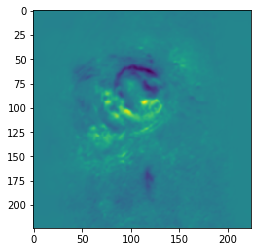

fx (56, 56)


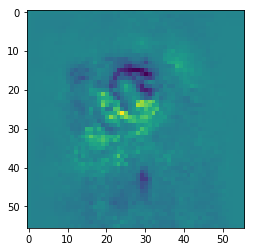

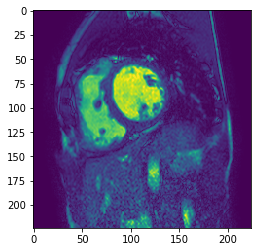

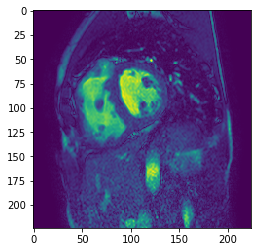

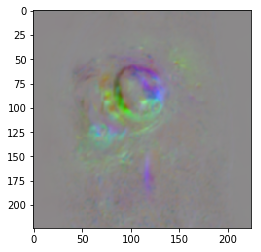

2019-11-18 16:57:34,501 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


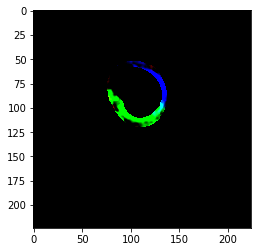

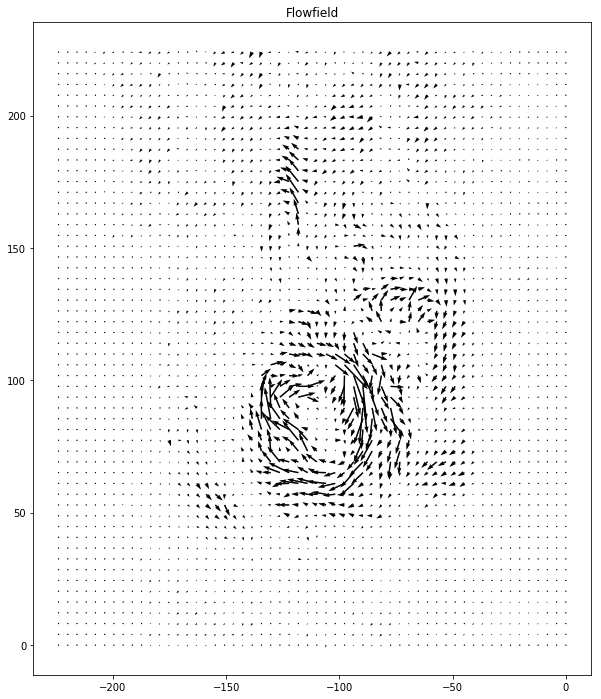

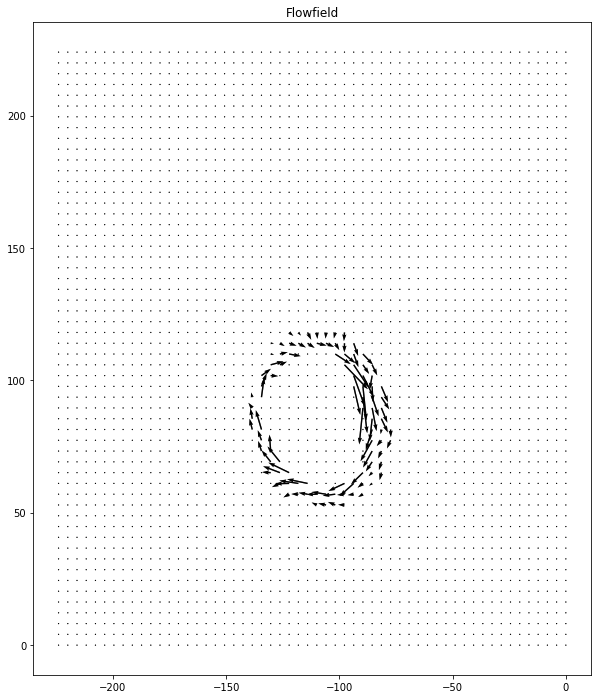

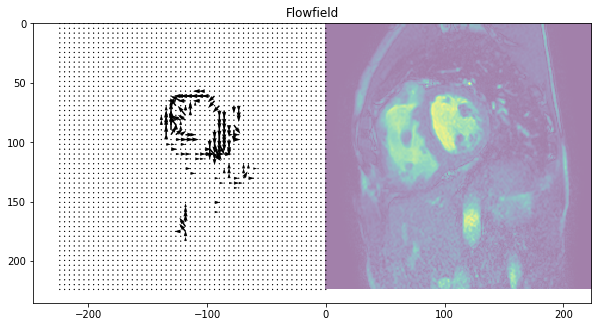

In [114]:
# cut one vector out
img = 101
z = 8
f_ = flowfield[img][z]
print(f_.shape)

N = 4
nx = f_.shape[0]//N

f_x = f_[...,1]
print('f_x', f_x.shape)
plt.imshow(f_x)
plt.show()

Fx = f_x[::N, ::N]
print('fx', Fx.shape)
plt.imshow(Fx)
plt.show()


nrows, ncols = Fx.shape

plt.imshow(i1[img][z])
plt.show()

plt.imshow(i2[img][z])
plt.show()

f_n = normalise_image(f_)

plt.imshow(f_n)
plt.show()

f_n_m = f_ * np.stack([m_2[img][z][...,2], m_2[img][z][...,2], m_2[img][z][...,2]], axis=-1)
plt.imshow(f_n_m)
plt.show()

flow_z = f_[...,0].copy()
flow_x = f_[...,1].copy()
flow_y = f_[...,2].copy()

# filter small z movements
flow_z[(flow_z > -0.7) & (flow_z < 0.7)] = 0
# filter small x movements
flow_x[(flow_x > -2.5) & (flow_x < 1.5)] = 0
# filter small y movements
flow_y[(flow_y > -2.5) & (flow_y < 1.5)] = 0
flow_ = np.stack([flow_z, flow_x, flow_y], axis=-1)

create_quiver_plot(f_)
create_quiver_plot(f_n_m)

fig, ax = plt.subplots(figsize=(10, 12))
ax.imshow(i2[img][z], alpha=0.5)
create_quiver_plot(flow_, ax)




2019-11-18 16:11:19,110 INFO Image-shape: (224, 224)
2019-11-18 16:11:19,111 INFO Image data points: 45591
2019-11-18 16:11:19,112 INFO Image mean: 0.151
2019-11-18 16:11:19,113 INFO Image max: 1.000
2019-11-18 16:11:19,115 INFO Image min: 0.000
2019-11-18 16:11:19,115 INFO Mask-shape: (224, 224, 3)
2019-11-18 16:11:19,116 INFO RV mask data points: 1092
2019-11-18 16:11:19,117 INFO Myo mask data points: 649
2019-11-18 16:11:19,117 INFO LV mask data points: 1343
2019-11-18 16:11:19,118 INFO RV mask 0.02176339365541935% of total pixels.
2019-11-18 16:11:19,118 INFO Myo mask 0.012934470549225807% of total pixels.
2019-11-18 16:11:19,119 INFO LV mask 0.02676578424870968% of total pixels.


(1, 16, 224, 224, 1)
(1, 16, 224, 224, 4)
(16, 224, 224, 3)
[-0.93358546 -1.2738464   2.950707  ]


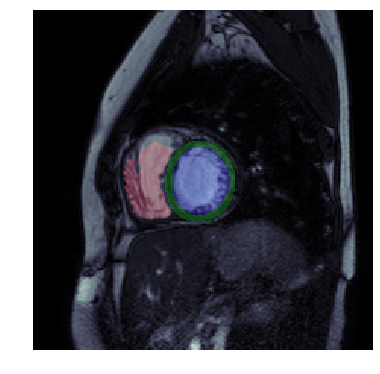

2019-11-18 16:11:19,260 INFO Image-shape: (224, 224)
2019-11-18 16:11:19,262 INFO Image data points: 45436
2019-11-18 16:11:19,263 INFO Image mean: 0.134
2019-11-18 16:11:19,264 INFO Image max: 0.967
2019-11-18 16:11:19,266 INFO Image min: 0.000
2019-11-18 16:11:19,267 INFO Mask-shape: (224, 224, 3)
2019-11-18 16:11:19,267 INFO RV mask data points: 1060
2019-11-18 16:11:19,268 INFO Myo mask data points: 653
2019-11-18 16:11:19,268 INFO LV mask data points: 715
2019-11-18 16:11:19,269 INFO RV mask 0.021125636994838715% of total pixels.
2019-11-18 16:11:19,269 INFO Myo mask 0.013014189898967743% of total pixels.
2019-11-18 16:11:19,270 INFO LV mask 0.014249840751290321% of total pixels.


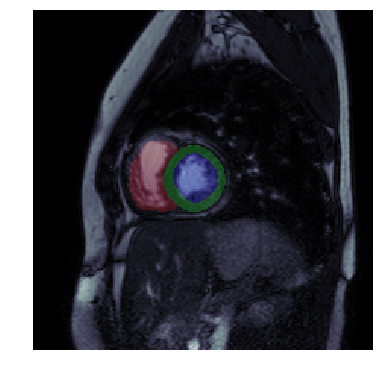

break


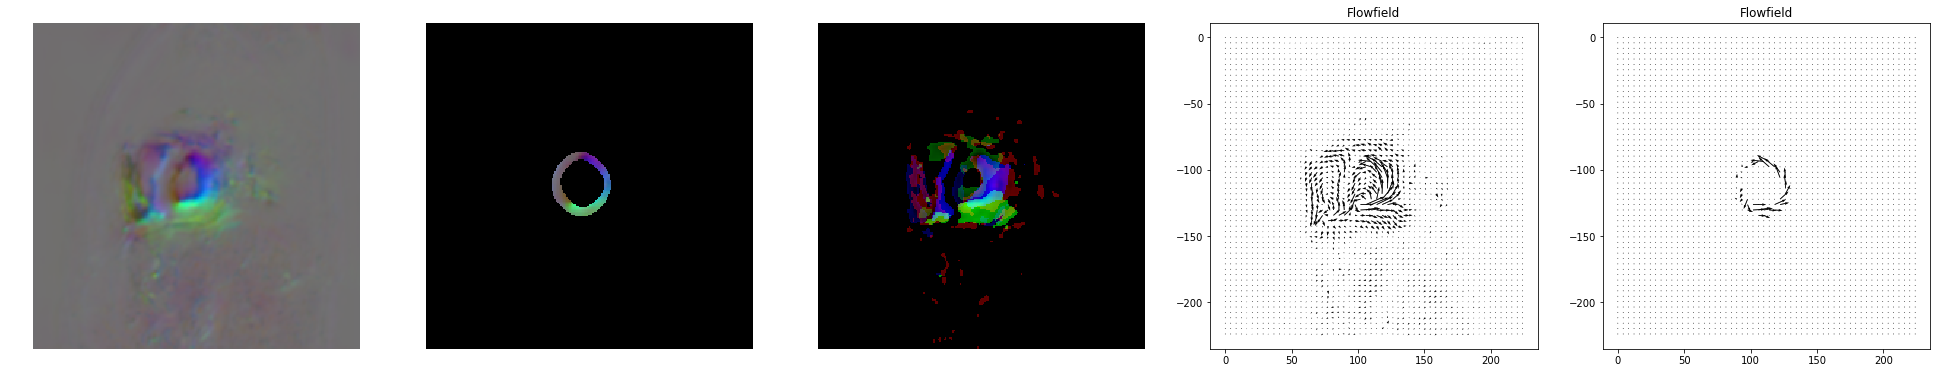

In [100]:

from src.visualization.visualize import create_quiver_plot
from src.data.preprocess import normalise_image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last'

# write the flowfields as numpy images to disk
file_root = 'data/interim/motion/3d/gcn/ed_es/'
flow_names = list()
mask1_names = list()
mask2_names = list()
ensure_dir(file_root)

z = 6
patient = 125

n = 0

for flowfield_3d, (img1, msk1), (img2, msk2) in zip(flowfield, generator1, generator2):
    if n==patient:
        print(img1.shape)
        print(msk1.shape)
        print(flowfield_3d.shape)
        img1 = img1[0,z,:,:,0]
        msk1 = msk1[0,z,:,:,:]
        img2 = img2[0,z,:,:,0]
        msk2 = msk2[0,z,:,:,:]
        
        flow = flowfield_3d[z,...]
        flow_ = flow.copy()
        flow_masked_ = flow.copy()
        
        print(flow[100,125,:])
        
        #patient = row['patient']
        #t = row['t_norm']
        
        # image & mask
        show_2D_or_3D(img1,msk1)
        plt.show()
        show_2D_or_3D(img2,msk2)
        plt.show()
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(34,6))
        
        flow_n = normalise_image(flow.copy())
        flow_masked_n = flow_n * np.stack([msk2[...,2], msk2[...,2], msk2[...,2]], axis=-1).astype(np.bool)
        flow_masked_[~np.stack([msk2[...,2], msk2[...,2], msk2[...,2]], axis=-1).astype(np.bool)] = 0
        
        # flowfield normalised
        ax1.imshow(flow_n);
        ax1.set_axis_off();

        # flowfield masked and normalised
        ax2.imshow(flow_masked_n);
        ax2.set_axis_off();
        
        flow_z = flow[...,0].copy()
        flow_x = flow[...,1].copy()
        flow_y = flow[...,2].copy()

        # flowfield filter by small vectors
        # filter small z movements
        flow_z[(flow_z > -0.7) & (flow_z < 0.7)] = flow.min()
        # filter small x movements
        flow_x[(flow_x > -1.5) & (flow_x < 1.5)] = flow.min()
        # filter small y movements
        flow_y[(flow_y > -1.5) & (flow_y < 1.5)] = flow.min()
        flow = np.stack([flow_z, flow_x, flow_y], axis=-1)
        # show flowfield as rgb with small vectors filtered
        ax3.imshow(normalise_image(flow));
        ax3.set_axis_off();
        
        # create quiver plot
        ax4 = create_quiver_plot(flow_[...,1:], ax4);
        
        # 
        ax4 = create_quiver_plot(flow_masked_, ax5);

    if n>patient:
        print('break')
        break
        
    n = n + 1


In [48]:
def create_quiver_plot_temp(flowfield_2d=None, ax=None):
    """
    Function to create an easy flowfield from the voxelmorph output
    Needs a 2D flowfield, function can handle 2D or 3D vectors as channels
    :param flowfield_2d: numpy array with shape x, y, vectors
    :param ax: matplotlib ax object which should be used for plotting,
    create a new ax object if none is given
    :return: ax to plot or save
    """

    N = 4  # take only every n vector
    nx = 224  # define ticks in x
    ny = 224  # define ticks in y
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 12))

    # extract flowfield for x and y
    if flowfield_2d.shape[-1] == 3:  # originally a 3d flowfield
        print('3')
        X_ = flowfield_2d[..., 1]
        Y_ = flowfield_2d[..., 2]
    elif flowfield_2d.shape[-1] == 2:  # 2d flowfield
        X_ = flowfield_2d[..., 0]
        Y_ = flowfield_2d[..., 1]

    # slice flowfield, take every N value
    Fx = X_[::N, ::N]
    Fy = Y_[::N, ::N]
    nrows, ncols = Fx.shape

    # create a grid with the size nx/ny and ncols/nrows
    x_ = np.linspace(0, nx, ncols)
    y_ = np.linspace(0, ny, nrows)
    xi, yi = np.meshgrid(x_, y_, indexing='xy')

    # plot
    ax.set_title('Flowfield')
    ax.quiver(xi, yi, Fx, Fy, alpha=.5)
    ax.quiver(xi, yi, Fx, Fy, linewidth=.5)
    ax.set_ylim(ax.get_ylim()[1], ax.get_ylim()[0])
    return ax

In [ ]:
for patient, t, flowfield_3d in zip(df_motion['patient'], df_motion['t_norm'], flowfield):
    f_path = os.path.join(file_root, 'flowfield_3d_{}_{}.npy'.format(patient, t))
    flow_names.append(f_path)

# store path to motions in new dataset
df_motion.shape
len(flow_names)
df_motion['flowfield_3d'] = flow_names

(1, 16, 224, 224, 1)
(1, 16, 224, 224, 4)


(1, 16, 224, 224, 4)

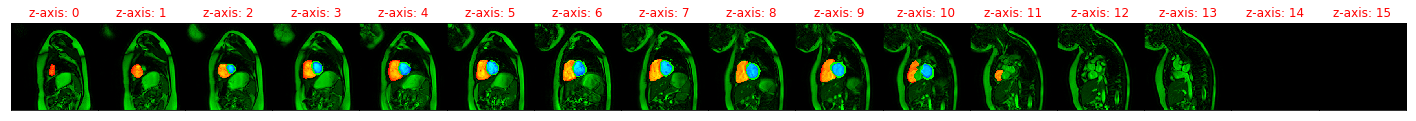

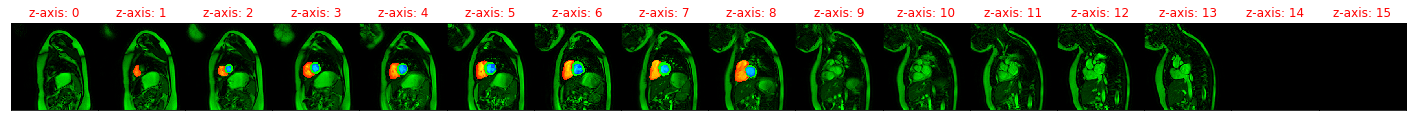

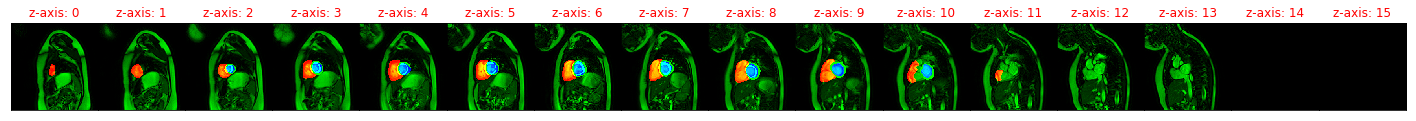

In [24]:
n = 0
for (i1, m1), (i2,m2) in zip(generator1, generator2):
    if n<1:
        print(i1.shape)
        print(m1.shape)
        show_2D_or_3D(i1[0,...,0],m1[0,...])
        show_2D_or_3D(i2[0,...,0],m2[0,...])
        m = m1 + m2
        m.shape
        show_2D_or_3D(i2[0,...,0],m[0,...])
    else:
        break
    n = n +1 